In [5]:
%config IPCompleter.greedy=True

In [6]:
import sys
sys.path.append("../..") # relative path to module toolkit

In [7]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight 
from keras import optimizers
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# setup
batch_size = 3
train_dir = "../../../images/images_species/train/"
val_dir = "../../../images/images_species/val/"
data_dir ="./train_augmented"
train_images = 12263
val_images = 3381
save_plot_name = "trainplot.png"
save_lossplot_name = "trainplot_loss.png"
model_name = 'highest_val_acc.h5'
labels = getLabelsFromDir(train_dir)

# args for train datagenerator
train_data_gen_args = dict(rescale=1./255.,
                            horizontal_flip=True,
                            width_shift_range=0.025,
                            height_shift_range=0.025,
                            rotation_range=20,
                            brightness_range=[0.6, 1.])

# args for train flow_from_dir
train_data_flow_args = dict(classes=labels,
                            class_mode="categorical",
                            batch_size=batch_size,
                            color_mode='rgb',
                            target_size=(224, 224),
                            shuffle=True,
                            #save_to_dir=data_dir,
                            #save_prefix="aug",
                            seed=1)

# args for validation datagenerator
val_data_gen_args = dict(rescale=1./255.)

optimizer = optimizers.SGD(lr=0.01, momentum=0, decay=0.0, nesterov=False)

In [9]:
steps_per_epoch = (train_images // 3) + 1
validation_steps = int(val_images/batch_size) + 1

In [10]:
### Model building ####
saved_model = 'highest_val_acc.h5'
model = load_model(saved_model)

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
# compile model
model.compile(loss='categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])


In [13]:
train_datagen = ImageDataGenerator(**train_data_gen_args)
val_datagen = ImageDataGenerator(**val_data_gen_args)

In [14]:
train_generator = train_datagen.flow_from_directory(train_dir, **train_data_flow_args)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)

Found 12263 images belonging to 200 classes.
Found 3381 images belonging to 200 classes.


In [15]:
filepath = model_name

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', mode='max', patience=12)

callbacks = [checkpoint, early_stop]

In [16]:
the_class_weight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

In [17]:
#Train
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=the_class_weight)

Epoch 1/50
4088/4088 [==============================] - 413s 101ms/step - loss: 0.1997 - acc: 0.9372 - val_loss: 1.4547 - val_acc: 0.7411

Epoch 00001: val_acc improved from -inf to 0.74113, saving model to highest_val_acc.h5
Epoch 2/50
4088/4088 [==============================] - 403s 98ms/step - loss: 0.1561 - acc: 0.9517 - val_loss: 0.9133 - val_acc: 0.8097

Epoch 00002: val_acc improved from 0.74113 to 0.80969, saving model to highest_val_acc.h5
Epoch 3/50
4088/4088 [==============================] - 407s 100ms/step - loss: 0.1090 - acc: 0.9668 - val_loss: 1.1589 - val_acc: 0.7866

Epoch 00003: val_acc did not improve from 0.80969
Epoch 4/50
4088/4088 [==============================] - 408s 100ms/step - loss: 0.0836 - acc: 0.9766 - val_loss: 0.8247 - val_acc: 0.8307

Epoch 00004: val_acc improved from 0.80969 to 0.83067, saving model to highest_val_acc.h5
Epoch 5/50
4088/4088 [==============================] - 414s 101ms/step - loss: 0.0711 - acc: 0.9795 - val_loss: 1.3300 - val_ac

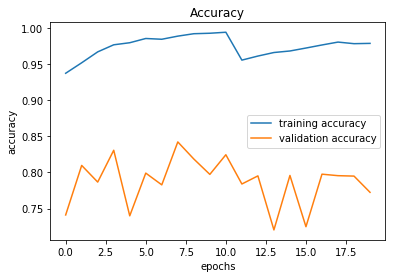

In [18]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(save_plot_name, bbox_inches='tight')
plt.show()

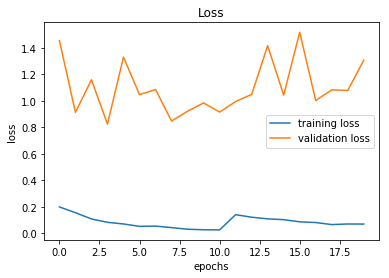

In [19]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig(save_lossplot_name, bbox_inches='tight')
plt.show()